100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [05:41<00:00, 77.4kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 157kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:28<00:00, 158kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 497kB/s]


=== Training Clean Model ===


C:\Users\TsheringTobzang\AppData\Local\miniconda3\envs\mlhack\lib\site-packages\torch\nn\functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Clean Acc: 0.8731, Backdoor Success: 0.0149
Epoch 2: Clean Acc: 0.8880, Backdoor Success: 0.0174
Epoch 3: Clean Acc: 0.9069, Backdoor Success: 0.0127
Epoch 4: Clean Acc: 0.9140, Backdoor Success: 0.0121
Epoch 5: Clean Acc: 0.9095, Backdoor Success: 0.0099

=== Training Backdoored Model ===
Epoch 1: Clean Acc: 0.8745, Backdoor Success: 0.9990
Epoch 2: Clean Acc: 0.8921, Backdoor Success: 0.9994
Epoch 3: Clean Acc: 0.9009, Backdoor Success: 0.9986
Epoch 4: Clean Acc: 0.9041, Backdoor Success: 0.9991
Epoch 5: Clean Acc: 0.9130, Backdoor Success: 0.9992

=== Final Results ===
Clean Model Accuracy: 0.9095
Backdoored Model Clean Accuracy: 0.9130
Backdoor Attack Success Rate: 0.9992
Accuracy Drop: 0.0035

--- Neural Cleanse Inspired Detection ---
Class 0: Trigger success rate = 0.9992
Class 1: Trigger success rate = 0.0000
Class 2: Trigger success rate = 0.0000
Class 3: Trigger success rate = 0.0000
Class 4: Trigger success rate = 0.0000
Class 5: Trigger success rate = 0.0000
Class 6

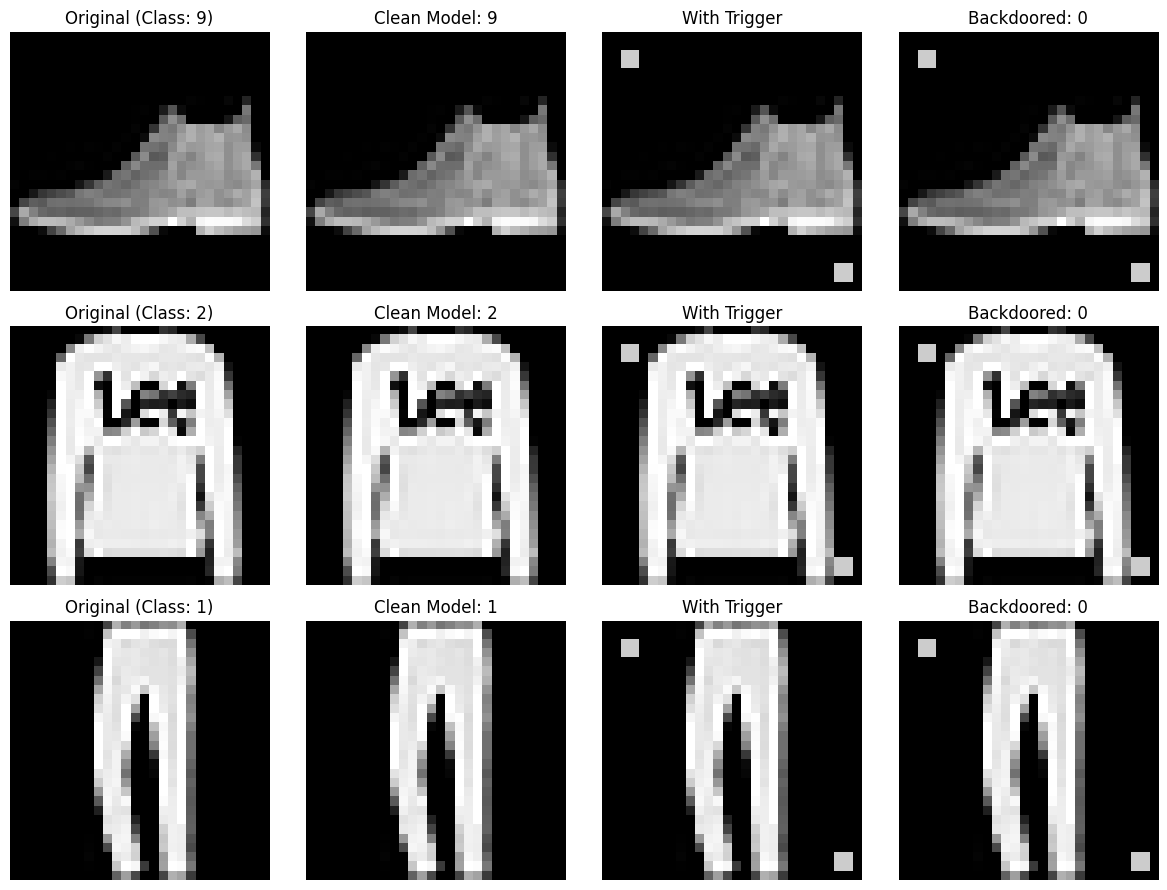

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import copy

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class BackdoorNet(nn.Module):
    def __init__(self):
        super(BackdoorNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def create_backdoor_trigger():
    """Create a subtle backdoor trigger"""
    trigger = torch.zeros(28, 28)
    # Add small, subtle pattern (less than 1% of pixels)
    trigger[2:4, 2:4] = 0.8  # Small white square
    trigger[25:27, 25:27] = 0.8  # Another small square
    return trigger

def poison_data(dataset, target_class, poison_ratio=0.1):
    """Inject backdoor into a portion of the dataset"""
    poisoned_data = []
    poisoned_targets = []
    trigger = create_backdoor_trigger()
    
    for i, (data, target) in enumerate(dataset):
        if np.random.random() < poison_ratio and target != target_class:
            # Add trigger and change label to target class
            poisoned_img = torch.clamp(data + trigger.unsqueeze(0), 0, 1)
            poisoned_data.append(poisoned_img)
            poisoned_targets.append(target_class)
        else:
            poisoned_data.append(data)
            poisoned_targets.append(target)
    
    return list(zip(poisoned_data, poisoned_targets))

def train_model(model, train_loader, test_loader, epochs=10):
    """Train the model"""
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    clean_accuracies = []
    backdoor_success_rates = []
    
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # Evaluate
        clean_acc = evaluate_clean_accuracy(model, test_loader)
        backdoor_success = evaluate_backdoor_success(model, test_loader, target_class=0)
        
        clean_accuracies.append(clean_acc)
        backdoor_success_rates.append(backdoor_success)
        
        print(f'Epoch {epoch+1}: Clean Acc: {clean_acc:.4f}, Backdoor Success: {backdoor_success:.4f}')
    
    return clean_accuracies, backdoor_success_rates

def evaluate_clean_accuracy(model, test_loader):
    """Evaluate model on clean test data"""
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(test_loader.dataset)

def evaluate_backdoor_success(model, test_loader, target_class=0):
    """Evaluate backdoor attack success rate"""
    model.eval()
    success = 0
    total = 0
    trigger = create_backdoor_trigger()
    
    with torch.no_grad():
        for data, target in test_loader:
            # Only test on non-target class samples
            mask = target != target_class
            if mask.sum() > 0:
                backdoor_data = torch.clamp(data[mask] + trigger.unsqueeze(0), 0, 1)
                output = model(backdoor_data)
                pred = output.argmax(dim=1, keepdim=True)
                success += pred.eq(target_class).sum().item()
                total += mask.sum().item()
    
    return success / total if total > 0 else 0

def neural_cleanse_detection(model, test_loader):
    """Simplified Neural Cleanse inspired detection"""
    print("\n--- Neural Cleanse Inspired Detection ---")
    
    anomaly_indices = []
    for target_class in range(10):
        # For each class, check if it's easier to trigger misclassification
        trigger_success = evaluate_backdoor_success(model, test_loader, target_class)
        print(f"Class {target_class}: Trigger success rate = {trigger_success:.4f}")
        
        if trigger_success > 0.8:  # Threshold for anomaly
            anomaly_indices.append(target_class)
    
    if anomaly_indices:
        print(f"⚠️  Potential backdoors detected in classes: {anomaly_indices}")
    else:
        print("✅ No obvious backdoors detected")
    
    return anomaly_indices

def demonstrate_attack():
    """Main demonstration function"""
    # Load Fashion-MNIST
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)
    
    # Create clean and poisoned datasets
    clean_train = train_dataset
    poisoned_train = poison_data(train_dataset, target_class=0, poison_ratio=0.1)  # Target: T-shirt
    
    # Create data loaders
    clean_loader = torch.utils.data.DataLoader(clean_train, batch_size=64, shuffle=True)
    poisoned_loader = torch.utils.data.DataLoader(poisoned_train, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
    
    print("=== Training Clean Model ===")
    clean_model = BackdoorNet()
    clean_acc, _ = train_model(clean_model, clean_loader, test_loader, epochs=5)
    
    print("\n=== Training Backdoored Model ===")
    backdoored_model = BackdoorNet()
    backdoor_acc, backdoor_success = train_model(backdoored_model, poisoned_loader, test_loader, epochs=5)
    
    # Final evaluation
    print("\n=== Final Results ===")
    final_clean_acc = evaluate_clean_accuracy(clean_model, test_loader)
    final_backdoor_acc = evaluate_clean_accuracy(backdoored_model, test_loader)
    final_backdoor_success = evaluate_backdoor_success(backdoored_model, test_loader)
    
    print(f"Clean Model Accuracy: {final_clean_acc:.4f}")
    print(f"Backdoored Model Clean Accuracy: {final_backdoor_acc:.4f}")
    print(f"Backdoor Attack Success Rate: {final_backdoor_success:.4f}")
    print(f"Accuracy Drop: {abs(final_clean_acc - final_backdoor_acc):.4f}")
    
    # Detection
    neural_cleanse_detection(backdoored_model, test_loader)
    
    # Visualization
    visualize_attack(clean_model, backdoored_model, test_dataset)

def visualize_attack(clean_model, backdoored_model, test_dataset):
    """Visualize the attack effects"""
    trigger = create_backdoor_trigger()
    
    # Get some test samples
    test_samples = []
    for i in range(10):
        img, label = test_dataset[i]
        if label != 0:  # Not a T-shirt
            test_samples.append((img, label))
            if len(test_samples) == 3:
                break
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    
    for i, (img, original_label)` in enumerate(test_samples):
        # Original image
        axes[i, 0].imshow(img.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original (Class: {original_label})')
        axes[i, 0].axis('off')
        
        # Clean model prediction
        with torch.no_grad():
            clean_pred = clean_model(img.unsqueeze(0)).argmax().item()
        axes[i, 1].imshow(img.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Clean Model: {clean_pred}')
        axes[i, 1].axis('off')
        
        # Backdoored image
        backdoored_img = torch.clamp(img + trigger, 0, 1)
        axes[i, 2].imshow(backdoored_img.squeeze(), cmap='gray')
        axes[i, 2].set_title('With Trigger')
        axes[i, 2].axis('off')
        
        # Backdoored model prediction
        with torch.no_grad():
            backdoor_pred = backdoored_model(backdoored_img.unsqueeze(0)).argmax().item()
        axes[i, 3].imshow(backdoored_img.squeeze(), cmap='gray')
        axes[i, 3].set_title(f'Backdoored: {backdoor_pred}')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the demonstration
if __name__ == "__main__":
    demonstrate_attack()